In [1]:
from sklearn.neighbors      import KDTree
from random                 import sample
from sklearn.decomposition  import PCA
import tadasets
import numpy                as np
import matplotlib.pyplot    as plt
import warnings
warnings.filterwarnings("ignore")

In [255]:
class Simplex:
    """
    Represents the simplex skeleton of 
    our pointcloud.
    """

    def __init__(self):
        """
        Attributes
        ----------
        pointcloud : (n_samples, n_features) np.array
            The pointcloud data from which we build our simplex.
        simplex : np.array
            ???
        dim : int 
            dimension of our simplex.
        """
        self.pointcloud = None
        self.edges = None
        self.vis = None
        self.dims = None
        self.vars = None
    
    def find_visible_edge(self, idx, ind, dist):
        """
        Computes a list of the indexes of points visible from 
        the 'idx' point, and their distances from this point 
        (in ascending length)

        Parameters
        ----------
        idx : int
            Index of a point.
        ind : (k,) np.array
            Indexes of points connected to the idx point by KNN.
        dist : (k,) np.array
            Array of edge lengths from KNN.
        
        Returns
        -------
        visible_dist : (n_visible_edges,) np.array
            Lengths of visible edges.
        visible_ind : (n_visible_edges,) np.array
            Indexes of visible edges (self.pointcloud).
        """
        point = self.pointcloud[idx]
        # List of indexes for visible points from the 'idx' point
        # where the indexes are for 'ind' (not self.pointcloud)
        visible_points_idx = [] 
        visible = True

        for y_count, idy in enumerate(ind):
            y = self.pointcloud[idy]
            for idz in ind:
                if idz != idy:
                    z = self.pointcloud[idz]
                    cos_angle = np.dot(point - z, y - z)  
                    if cos_angle < 0:
                        visible = False
                        break
            if visible == True:
                visible_points_idx.append(y_count)   # should be ascending indexes for acsending distances
            visible = True
        
        visible_dist = dist[visible_points_idx]  
        visible_ind = ind[visible_points_idx] 

        return visible_ind, visible_dist 
    
    def find_safe_edges(self, idx, ind, dist, threshold_var, edge_sen):
        """
        Computes the list of safe edges of points which
        connecte to the 'idx' point.

        Parameters
        ----------
        idx : int
            Index of a point.
        ind : (k,) np.array
            Indexes of visible points connected to the idx point.
        dist : (k,) np.array
            Array of edge lengths.
        threshold_var : [0,1] float
            The threshold to estimate the local intrinsic dimension by PCA.
        edge_sen : positive float
            The sensitivity with which we choose safe edges.

        Returns
        -------
        ind : 1-D np.array
            Indexes of safe points connected to the 'idx' point.
        """
        point = self.pointcloud[idx]
        edges = self.pointcloud[ind] - point  # ascending by length
        dims = []
        vars = []
        threshold_edge = edge_sen * np.mean(dist)

        for j in range(2, len(edges)+1):  # need len != 1 
            pca = PCA()
            pca.fit_transform(edges[:j])
            var = pca.explained_variance_ratio_
            vars.append(var)
            dims.append(np.sum(var >= threshold_var))
            if j==2:
                dim0 = dim1 = np.sum(var >= threshold_var)
            else:
                dim1 = np.sum(var >= threshold_var)

            if dim1>dim0 and dist[j-1]-dist[j-2]>threshold_edge:
                return ind[:j-1], dims, vars
            
            dim0 = dim1

        return ind, dims, vars

    def build_edges(self, pointcloud, k=10, threshold_var=0.02, edge_sen=1):
        """
        Computes the edges of our simplex.

        Parameters
        ----------
        pointcloud : (n_samples, n_features) np.array
            The pointcloud data from which we build our simplex.
        k : int
            The number of NN we use.
        threshold_var : [0,1] float
            The threshold to estimate the local intrinsic dimension by PCA.
        edge_sen : positive float
            The sensitivity with which we choose safe edges.
        """
        n = len(pointcloud)
        self.pointcloud = pointcloud
        kd_tree = KDTree(pointcloud, leaf_size=2)  # ALREADY ORDERED ASCENDING
        dists, inds = kd_tree.query(pointcloud, k=k+1)
        dists = dists[:, 1:]  # removes points being compared to itself with KNN
        inds = inds[:, 1:]

        visible_edges = [self.find_visible_edge(i, inds[i], dists[i]) for i in range(n)]
        self.vis = visible_edges
        safe_edges = [self.find_safe_edges(i, visible_edges[i][0], visible_edges[i][1], threshold_var, edge_sen) for i in range(n)]
        print(len(safe_edges[0]))

        self.edges = [safe_edges[i][0] for i in range(n)]
        self.dims = [np.asarray(safe_edges[i][1]) for i in range(n)]
        self.vars = [safe_edges[i][2] for i in range(n)]

    def find_dim(self):
        """
        
        """
        pass

    

In [226]:
def test(idx, ind, dist, threshold_var=0.08, edge_sen=1):
        point = pointcloud[idx]
        edges = pointcloud[ind] - point  # ascending by length
        dims = []
        threshold_edge = edge_sen * np.mean(dist)

        for j in range(2, len(edges)+1):  # need len != 1
            #max_components = j  # why max_components?
            #pca = PCA(n_components=max_components)  
            pca = PCA()
            #try:
            pca.fit_transform(edges[:j])
            #except:
            #    print(ind)
            #    print(edges)
            #    print(edges[:j])
            var = pca.explained_variance_ratio_
            print(var)
            dims.append(np.sum(var >= threshold_var))
            if j==2:
                dim0 = dim1 = np.sum(var >= threshold_var)
            else:
                dim1 = np.sum(var >= threshold_var)

            if dim1>dim0 and dist[j-1]-dist[j-2]>threshold_edge:
                return ind[:j-1]
            
            dim0 = dim1

        return ind

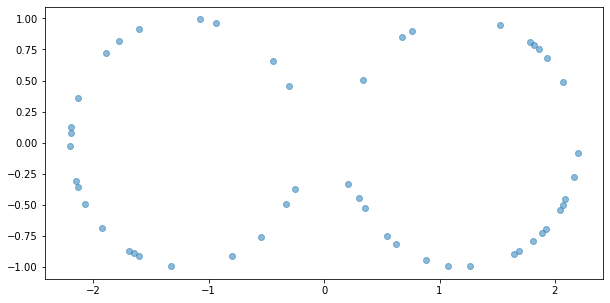

In [227]:
eyeglasses = np.loadtxt('/home/lz1919/Documents/UNI/year_three/summer_tda/code/eyeglasses_tight.txt')
pointcloud = np.array(sample(list(eyeglasses), 50))

fig = plt.figure(figsize =(10,5))
plt.scatter(pointcloud[:,0], pointcloud[:,1], alpha = 0.5);

In [269]:
test_set = np.loadtxt(open("eyeglasses_1.csv", "rb"), delimiter=",")

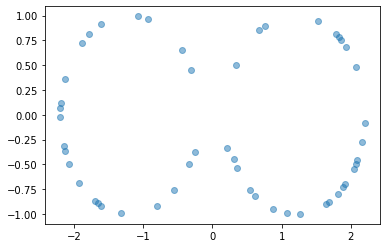

In [271]:
plt.scatter(test_set[:, 0], test_set[:, 1], alpha=0.5)

In [263]:
S = Simplex()
S.build_edges(pointcloud, k=10, threshold_var=0.08, edge_sen=0.1)

3


In [264]:
def plot_graph(local_neighborhood):
    fig = plt.figure(figsize =(10,5))
    plt.scatter(pointcloud[:,0], pointcloud[:,1], alpha = 0.5)
    for j in range(len(local_neighborhood)):
        for i in local_neighborhood[j]:
            plt.plot([pointcloud[j][0],pointcloud[i][0]], [pointcloud[j][1],pointcloud[i][1]])

def plot_graph2(local_neighborhood, inds, scatt=None):
    fig = plt.figure(figsize =(10,5))
    plt.scatter(pointcloud[:,0], pointcloud[:,1], alpha = 0.5)
    if scatt!=None:
        for k in scatt:
            plt.scatter(pointcloud[k,0], pointcloud[k,1], marker='x', color='red')
            plt.text(pointcloud[k,0]+.03, pointcloud[k,1]+.03, str(k), fontsize=9)
    for j in range(len(local_neighborhood)):
        for i in local_neighborhood[j]:
            plt.plot([pointcloud[inds[j]][0],pointcloud[i][0]], [pointcloud[inds[j]][1],pointcloud[i][1]])

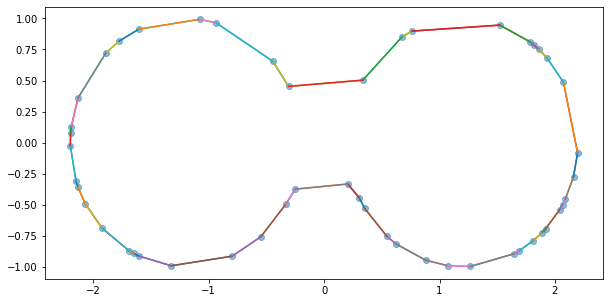

In [265]:
plot_graph(S.edges)

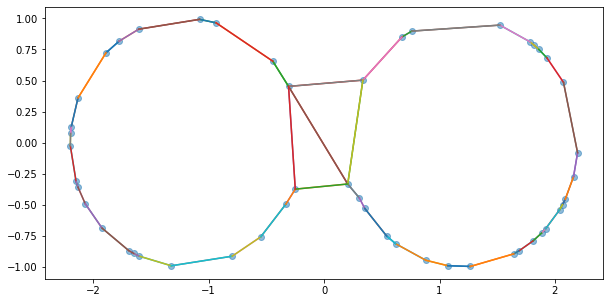

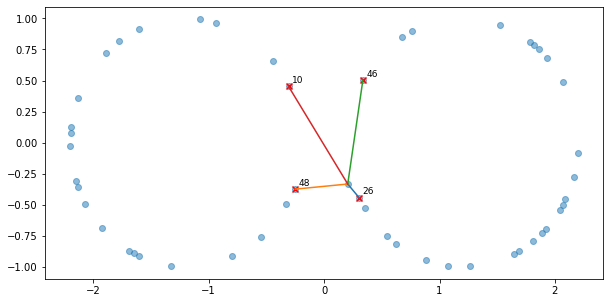

In [266]:
plot_graph([S.vis[i][0]  for i in range(len(S.vis))])
lis = [0]
plot_graph2([S.vis[i][0]  for i in lis], lis, [26, 48, 46, 10])

In [252]:
l = 0
print(S.vis[l])
print(S.dims[l])
print(S.vars[l])

(array([26, 48, 46, 10]), array([0.14982042, 0.45641988, 0.84706853, 0.93887795]))
[1 2 2]
[array([1.0000000e+00, 1.1639186e-34]), array([0.80902059, 0.19097941]), array([0.68721601, 0.31278399])]


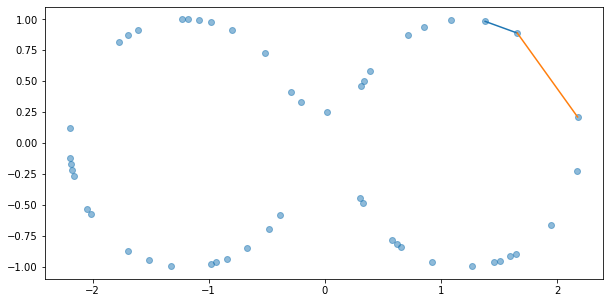

In [203]:
plot_graph([S.vis[i][0] for i in [0]])

In [67]:
S.edges[0]
x = [S.edges[i][0]  for i in range(len(S.edges))]

In [68]:
def plot_graph(local_neighborhood):
    fig = plt.figure(figsize =(10,5))
    plt.scatter(pointcloud[:,0], pointcloud[:,1], alpha = 0.5)
    for j in range(len(local_neighborhood)):
        for i in local_neighborhood[j]:
            plt.plot([pointcloud[j][0],pointcloud[i][0]], [pointcloud[j][1],pointcloud[i][1]])

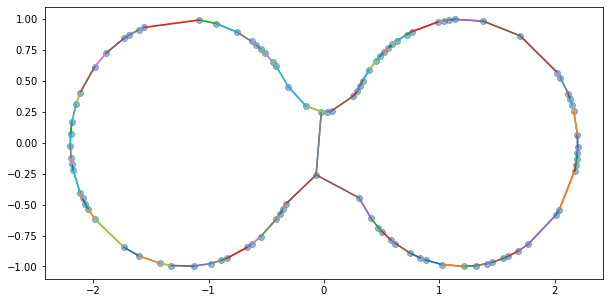

In [69]:
plot_graph(x)

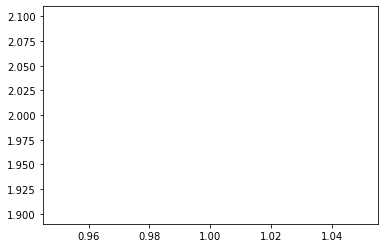

In [70]:
plt.plot([1, 1], [2,2])